In [ ]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 2
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [9]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [10]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [11]:
# # Review unperturbed elements
# elts_ast

In [12]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,306,733,b'ZTF18abiyevm',567274570115015018,3341,58321.274572,275.834958,-12.178240,0.099376,-0.976101,...,0.004095,0.080910,-0.982320,0.168822,2.050675,0.031258,6447.753750,0.999511,0.801975,False
1,6391,733,b'ZTF18ablpbwh',617122522515015016,8730,58371.122523,272.156750,-10.136454,0.037046,-0.972528,...,0.003837,0.016116,-0.975703,0.218503,2.491969,0.024005,4951.468379,0.999712,0.472962,False
2,6392,733,b'ZTF18ablpbwh',618126362515015025,8913,58372.126366,272.156760,-10.136446,0.037046,-0.972528,...,0.003830,0.017464,-0.975564,0.219021,2.503645,0.022568,4655.153797,0.999745,0.418050,False
3,6393,733,b'ZTF18ablpbwh',611146562515015015,7585,58365.146562,272.156733,-10.136444,0.037046,-0.972528,...,0.003876,0.010155,-0.976524,0.215169,2.423439,0.030883,6370.298847,0.999523,0.782824,False
4,12249,733,b'ZTF18ablwzcc',584190354815015015,4647,58338.190359,273.272132,-13.497675,0.055502,-0.983530,...,0.004023,0.030085,-0.980846,0.192450,2.155818,0.032724,6750.065879,0.999465,0.878934,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290766,5650772,324582,b'ZTF20aaqvhnd',1150176700415015000,96618,58904.176701,48.664349,31.318054,0.564235,0.795279,...,-0.001786,0.584015,0.786561,0.200621,2.748814,0.030221,6233.797319,0.999543,0.749638,False
290767,5650773,324582,b'ZTF20aaqvhns',1150176245615015007,96617,58904.176250,45.820577,29.378228,0.607285,0.768505,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.029465,6077.915470,0.999566,0.712618,False
290768,5650789,324582,b'ZTF20aaqvhnm',1150176245015015006,96617,58904.176250,48.881586,28.300138,0.579016,0.797156,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.031743,6547.783696,0.999496,0.827049,False
290769,5650791,324582,b'ZTF20aaqvhog',1150176244815015007,96617,58904.176250,49.429756,29.370649,0.566783,0.802441,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.027275,5625.990260,0.999628,0.610591,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_pert_large_{random_seed:04d}.h5',
                name='model')

In [31]:
# model.load()

In [32]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     0.09  :   0.00 :  1800.46 :  7200.00
Mean     :     0.09  :   0.00 :  1800.46 :  7200.00
Median   :    -0.04  :   0.00 :  1807.21 :  7200.00
GeoMean  :     1.07  :   0.00 :  1800.45 :  7200.99
Min      :    -1.13  :   0.00 :  1792.81 :  7200.00
Max      :     3.51  :   0.00 :  1807.22 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


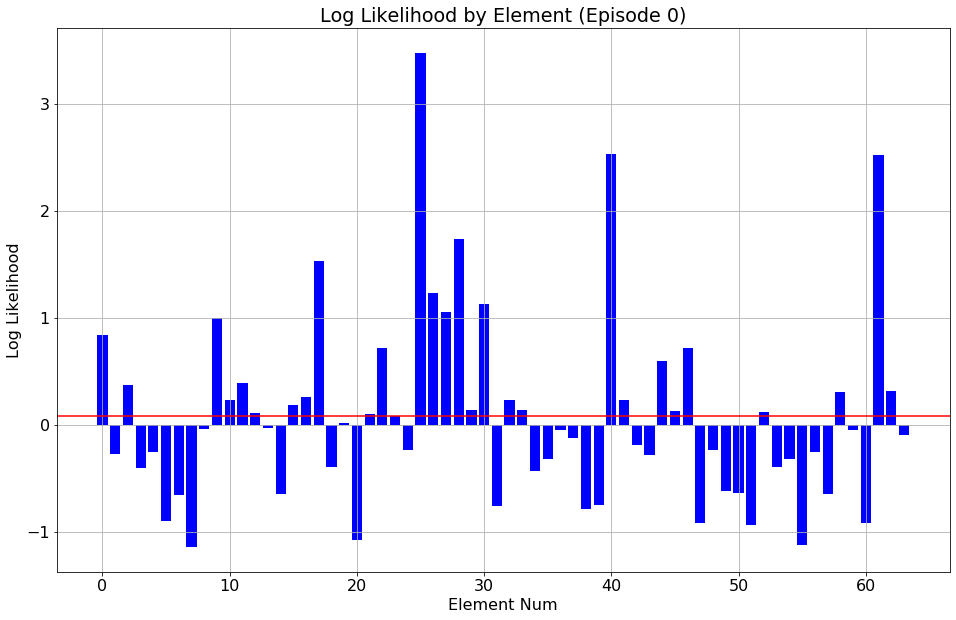

In [33]:
fig, ax = model.plot_bar('log_like', sorted=False)

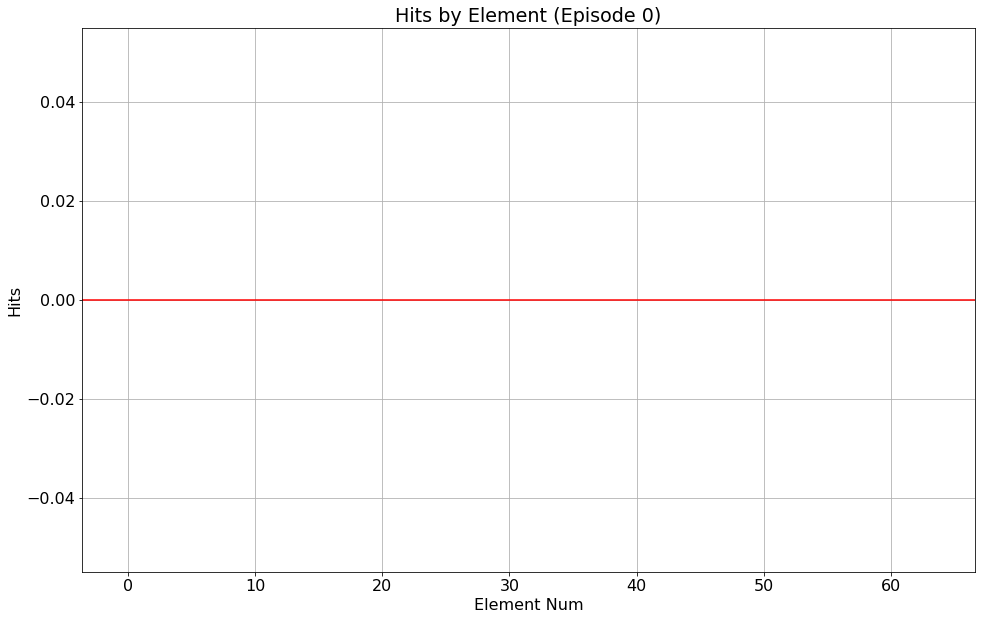

In [34]:
fig, ax = model.plot_bar('hits', sorted=False)

In [35]:
# raise ValueError

## Automated Training with Sieve Method


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 4s 982us/sample - loss: -17416.3076
Epoch 2/4
4096/4096 [==============================] - 2s 413us/sample - loss: -39893.5068
Epoch 3/4
4096/4096 [==============================] - 2s 407us/sample - loss: -68790.1029
Epoch 4/4
4096/4096 [==============================] - 2s 415us/sample - loss: -106706.5347
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1745.13 :  1745.13 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      1.03 :     1.03 :      nan
Mean Hits           :      0.0

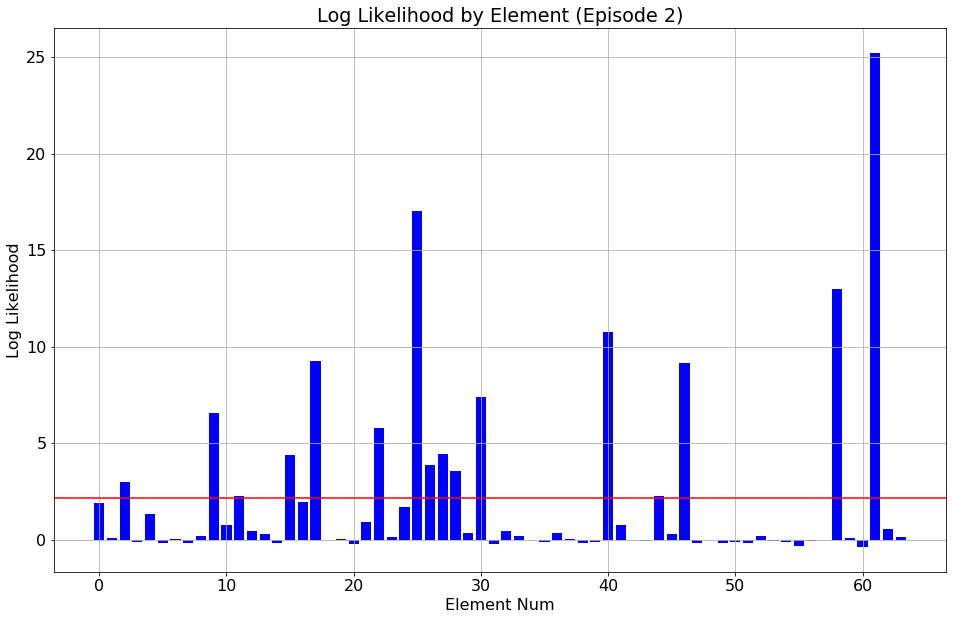

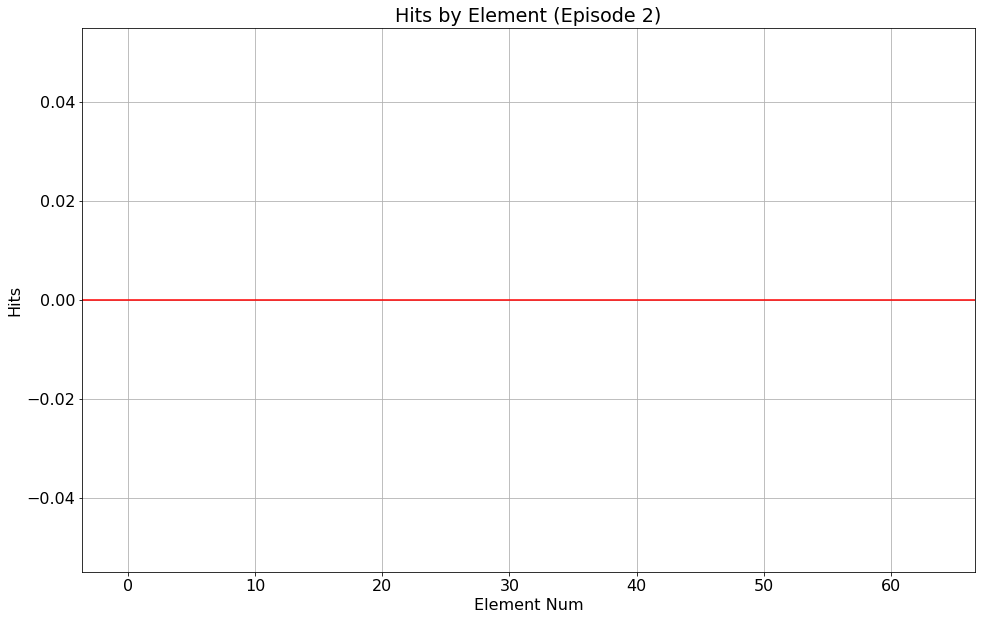


********************************************************************************
Round 2: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    512
effective_learning_rate=2.422e-04, training_time 27 sec.
Train on 4096 samples
Epoch 9/12
4096/4096 [==============================] - 5s 1ms/sample - loss: -244.0587
Epoch 10/12
4096/4096 [==============================] - 2s 488us/sample - loss: -320.0099
Epoch 11/12
4096/4096 [==============================] - 2s 491us/sample - loss: -347.7736
Epoch 12/12
4096/4096 [==============================] - 2s 499us/sample - loss: -367.4728
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1604.71 :  1604.71 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      9.37 :     9.37 : 

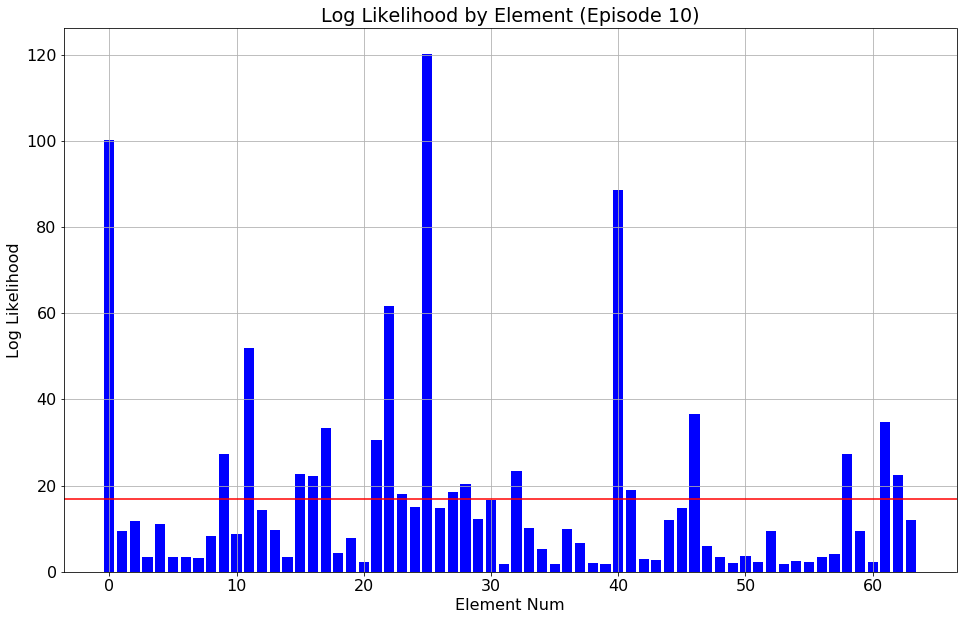

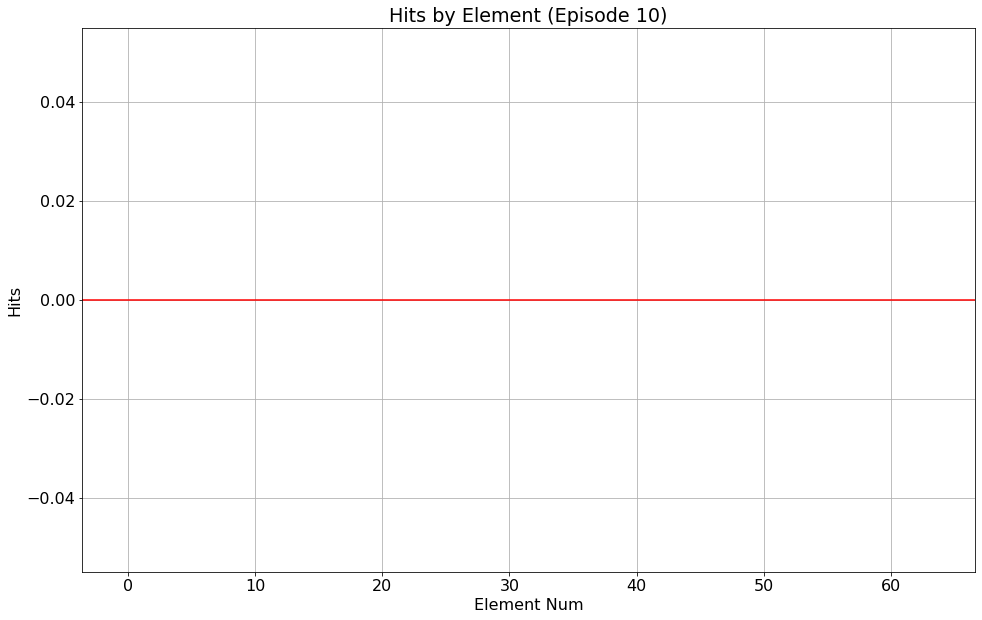


********************************************************************************
Round 3: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2560
effective_learning_rate=2.441e-04, training_time 109 sec.
Train on 4096 samples
Epoch 41/44
4096/4096 [==============================] - 4s 982us/sample - loss: -2747463.9570
Epoch 42/44
4096/4096 [==============================] - 2s 405us/sample - loss: -3501602.7539
Epoch 43/44
4096/4096 [==============================] - 2s 415us/sample - loss: -4452184.9922
Epoch 44/44
4096/4096 [==============================] - 2s 414us/sample - loss: -5643724.6719
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    727.85 :   727.85 :      nan arc seconds
Geom Mean Threshold :   5400.00 :  5400.00 :      nan arc seconds
Mean Log Likelihood :     27.23 :    27.23 :      nan
Mean Hits   

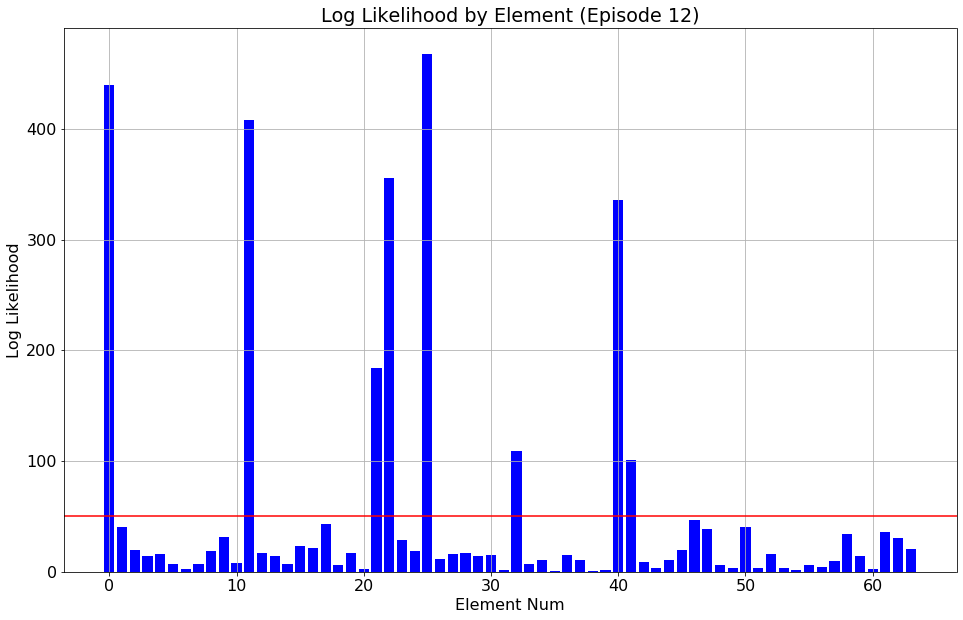

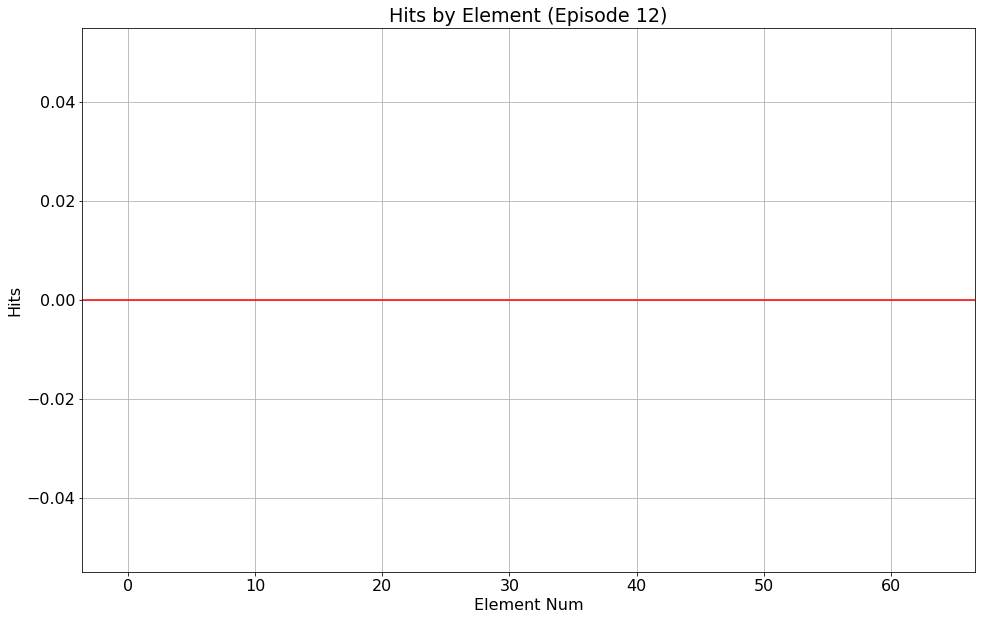


********************************************************************************
Round 4: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   3072
effective_learning_rate=2.365e-04, training_time 128 sec.
Train on 4096 samples
Epoch 49/52
4096/4096 [==============================] - 5s 1ms/sample - loss: -2364.6881
Epoch 50/52
4096/4096 [==============================] - 2s 529us/sample - loss: -2487.1027
Epoch 51/52
4096/4096 [==============================] - 2s 535us/sample - loss: -2541.0272
Epoch 52/52
4096/4096 [==============================] - 2s 525us/sample - loss: -2582.4923
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    490.73 :   490.73 :      nan arc seconds
Geom Mean Threshold :   5393.30 :  5393.30 :      nan arc seconds
Mean Log Likelihood :     63.55 :    6

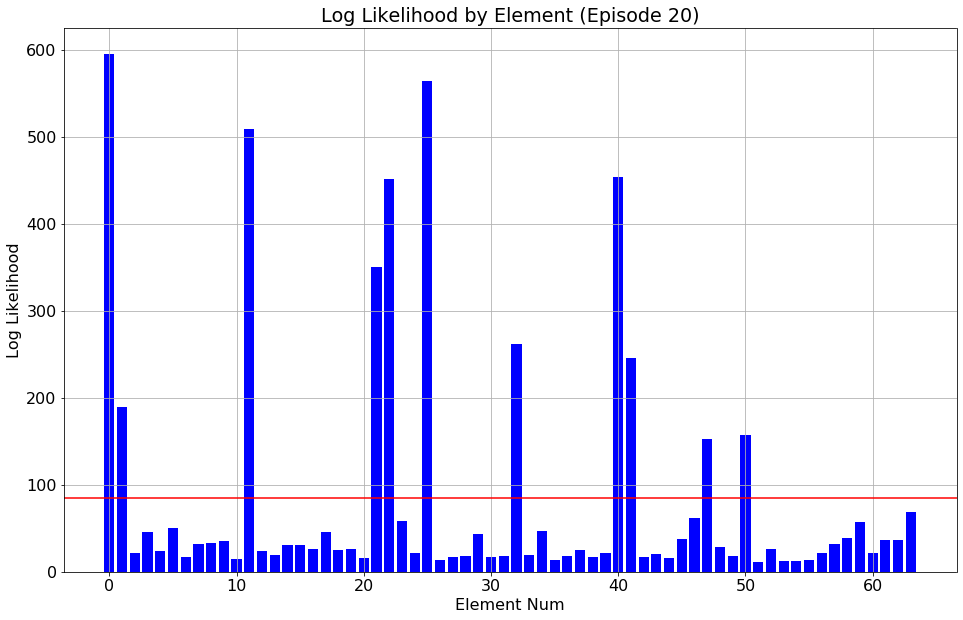

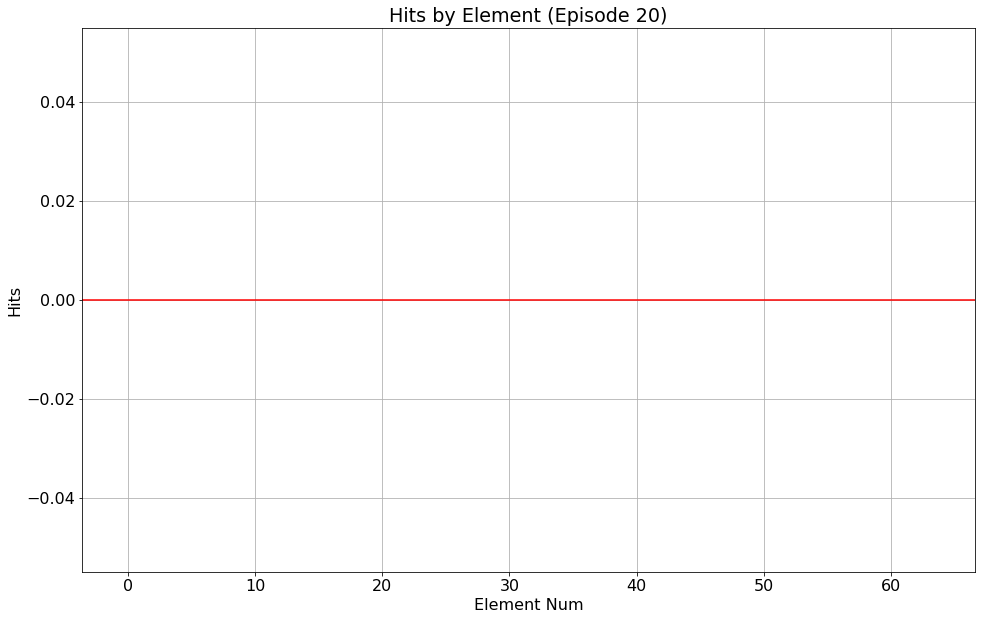


********************************************************************************
Round 5: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 20: Epoch   80, Batch   5120
effective_learning_rate=2.441e-04, training_time 216 sec.
Train on 4096 samples
Epoch 81/84
4096/4096 [==============================] - 4s 945us/sample - loss: -31591924.6562
Epoch 82/84
4096/4096 [==============================] - 2s 442us/sample - loss: -37105793.6875
Epoch 83/84
4096/4096 [==============================] - 2s 442us/sample - loss: -43564262.1875
Epoch 84/84
4096/4096 [==============================] - 2s 451us/sample - loss: -50872730.7500
Adjusted element weight down on 7 candidate elements. Mean weight = 9.45e-01
                    \  All Elts : Bad Elts : Good Elts (2)
Geom Mean Resolution:    282.01 :   293.75 :    79.58 arc seconds
Geom Mean Threshold :   3472.41 :  3519.09 :  2295.

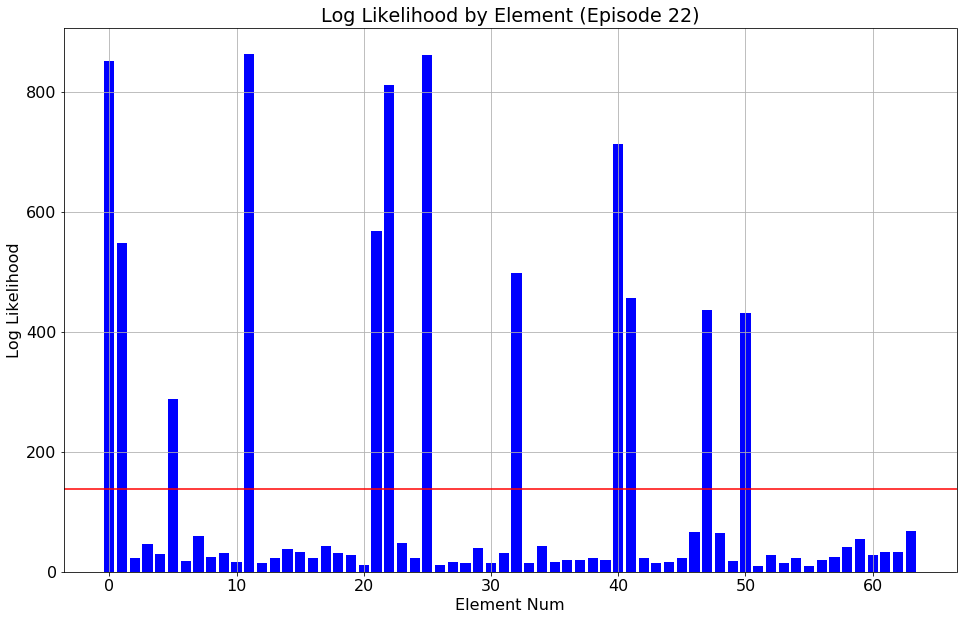

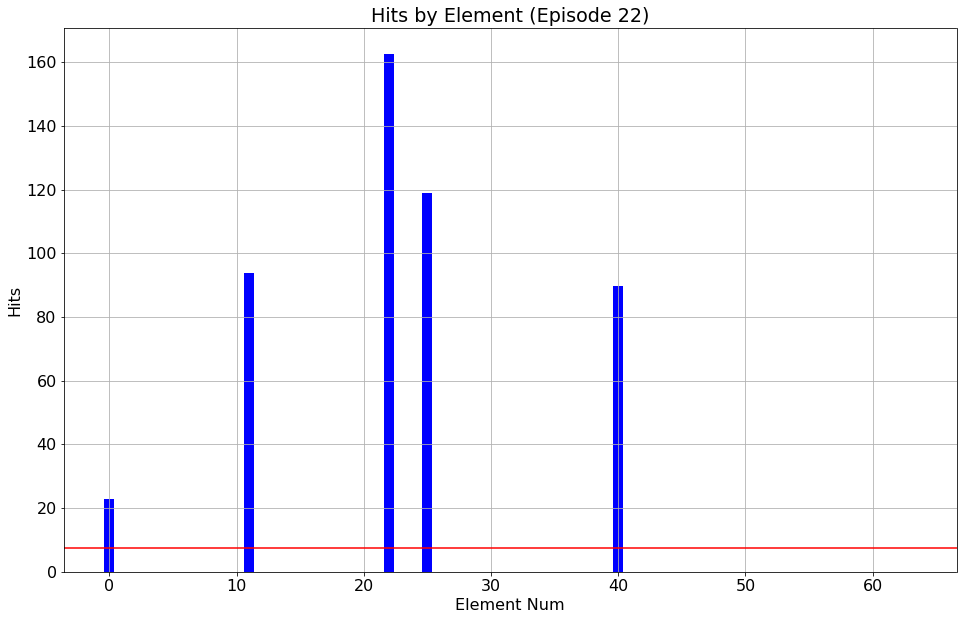


********************************************************************************
Round 6: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 22: Epoch   88, Batch   5632
effective_learning_rate=2.012e-04, training_time 236 sec.
Train on 4096 samples
Epoch 89/92
4096/4096 [==============================] - 5s 1ms/sample - loss: -5583.8173
Epoch 90/92
4096/4096 [==============================] - 2s 565us/sample - loss: -5748.1389
Epoch 91/92
4096/4096 [==============================] - 2s 549us/sample - loss: -5790.9593
Epoch 92/92
4096/4096 [==============================] - 2s 562us/sample - loss: -5830.6930
Adjusted element weight down on 2 candidate elements. Mean weight = 9.58e-01
                    \  All Elts : Bad Elts : Good Elts (5)
Geom Mean Resolution:    234.19 :   271.77 :    40.45 arc seconds
Geom Mean Threshold :   331

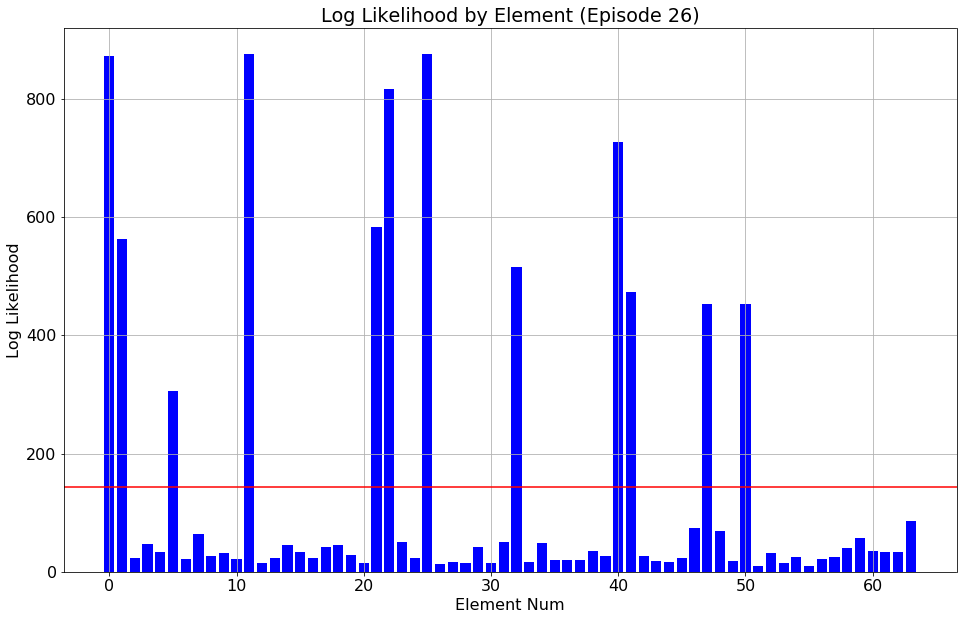

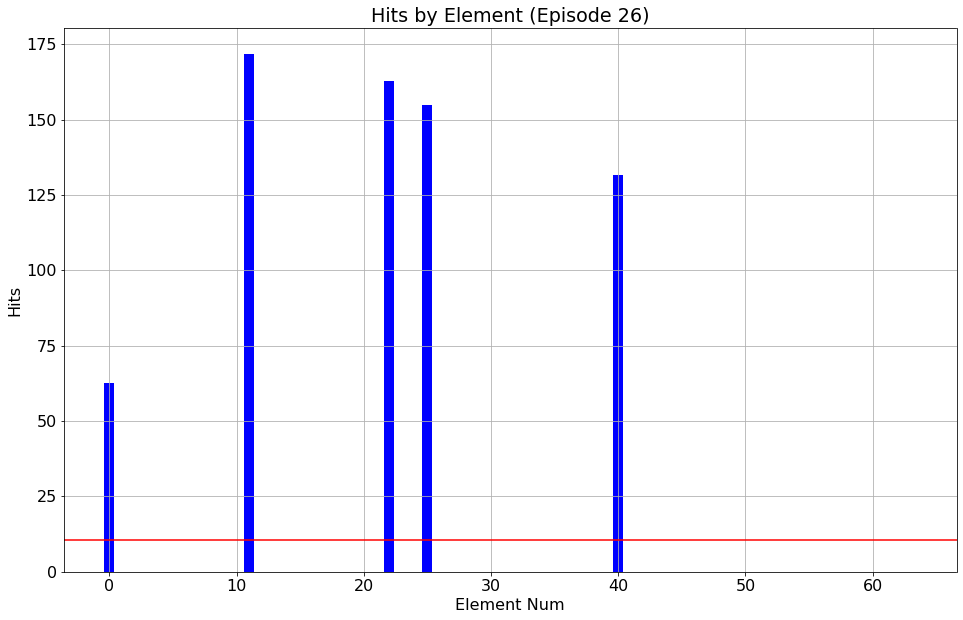


********************************************************************************
Round 7: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 26: Epoch  104, Batch   6656
effective_learning_rate=2.441e-04, training_time 282 sec.
Train on 4096 samples
Epoch 105/108
4096/4096 [==============================] - 4s 950us/sample - loss: -110113398.1250
Epoch 106/108
4096/4096 [==============================] - 2s 464us/sample - loss: -121541218.2500
Epoch 107/108
4096/4096 [==============================] - 2s 469us/sample - loss: -133882139.3750
Epoch 108/108
4096/4096 [==============================] - 2s 468us/sample - loss: -146960552.5000
Adjusted element weight down on 24 candidate elements. Mean weight = 8.12e-01
                    \  All Elts : Bad Elts : Good Elts (7)
Geom Mean Resolution:    196.01 :   244.18 :    32.74 arc seconds
Geom Mean Threshold :   2140.08 :  232

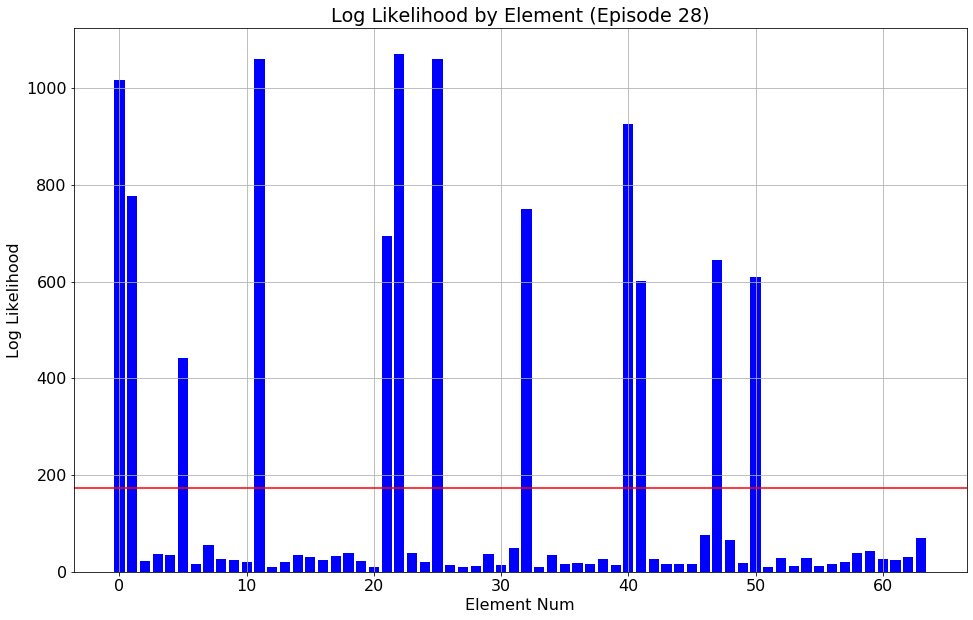

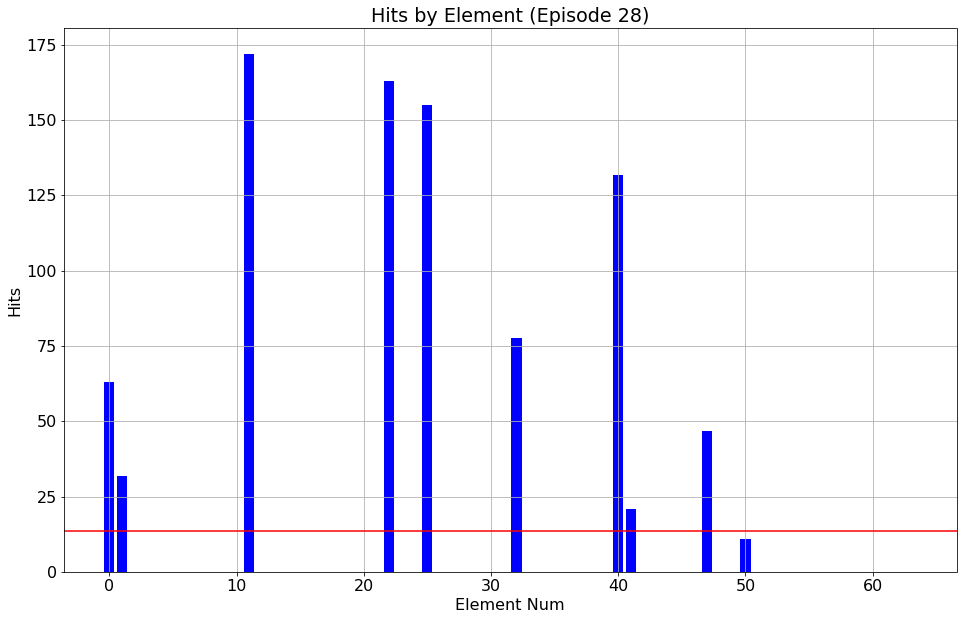


********************************************************************************
Round 8: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 28: Epoch  112, Batch   7168
effective_learning_rate=1.411e-04, training_time 303 sec.
Train on 4096 samples
Epoch 113/116
4096/4096 [==============================] - 5s 1ms/sample - loss: -3996.6121
Epoch 114/116
4096/4096 [==============================] - 2s 582us/sample - loss: -4186.1738
Epoch 115/116
4096/4096 [==============================] - 2s 570us/sample - loss: -4235.0224
Epoch 116/116
4096/4096 [==============================] - 2s 598us/sample - loss: -4274.2544
Adjusted element weight down on 8 candidate elements. Mean weight = 1.12e-01
                    \  All Elts : Bad Elts : Good Elts (9)
Geom Mean Resolution:    179.22 :   247.65 :    24.84 arc seconds
Geom Mean Threshold

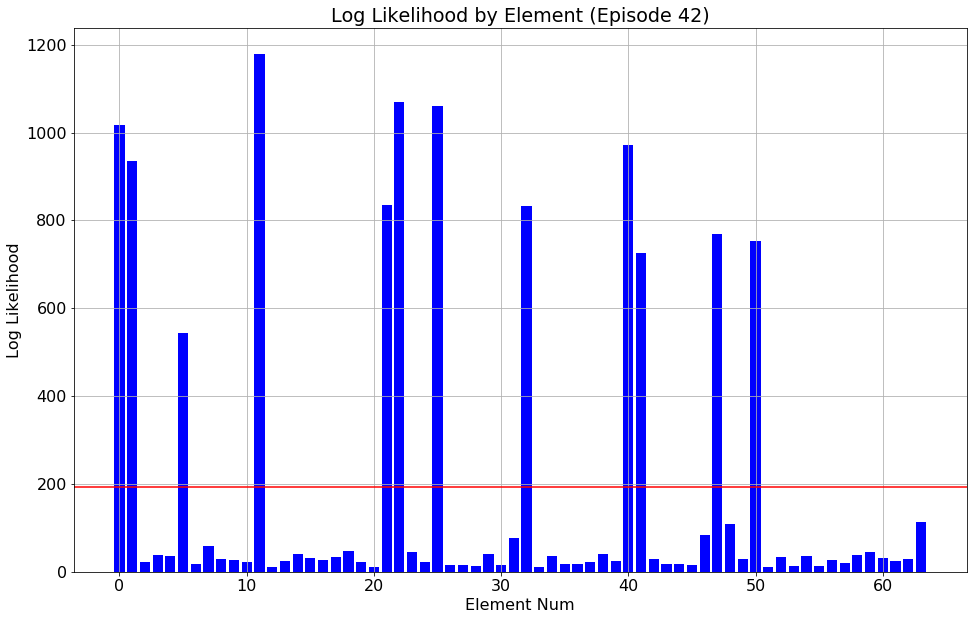

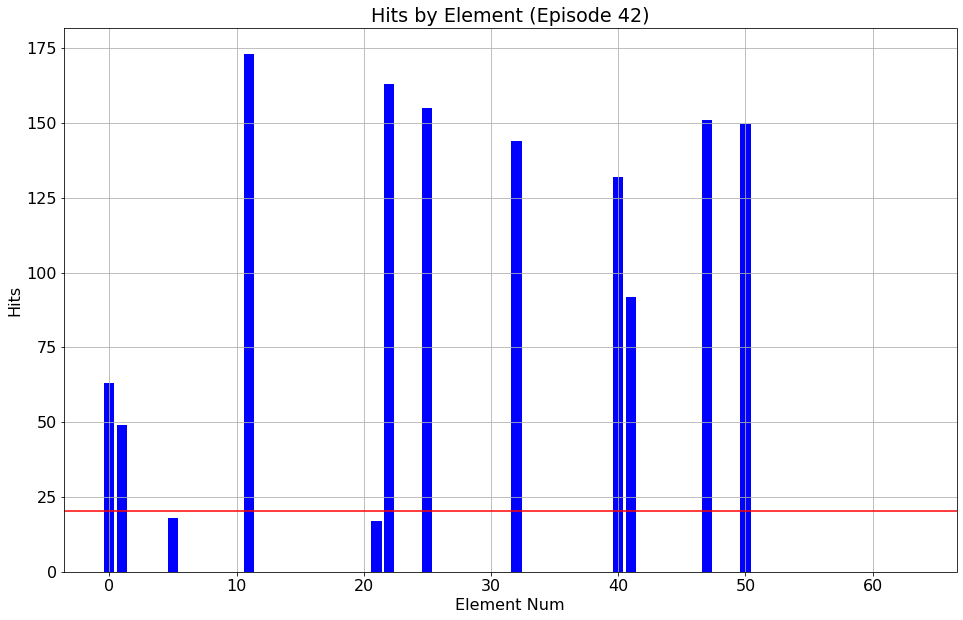


********************************************************************************
Round 5: 1024 batches @ LR 2^-13 in mixture mode.
********************************************************************************
Applying learning_rate 1.22e-04 (2.0^-13.0) for adaptive training.

Training episode 42: Epoch  145, Batch   9280
effective_learning_rate=1.221e-04, training_time 411 sec.
Train on 4096 samples
Epoch 146/149
4096/4096 [==============================] - 4s 1ms/sample - loss: -6677585625088.0000
Epoch 147/149
4096/4096 [==============================] - 2s 523us/sample - loss: -7079639900160.0000
Epoch 148/149
4096/4096 [==============================] - 2s 530us/sample - loss: -7481160073216.0000
Epoch 149/149
4096/4096 [==============================] - 2s 540us/sample - loss: -7892277764096.0000
Adjusted element weight down on 42 candidate elements. Mean weight = 6.72e-01
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:    154.97 :   243.93 : 

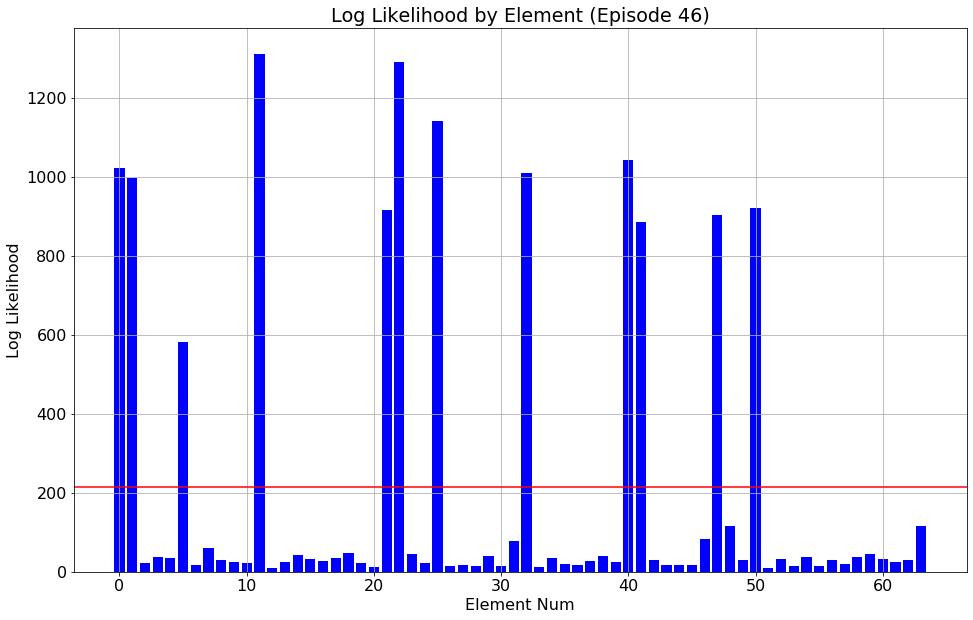

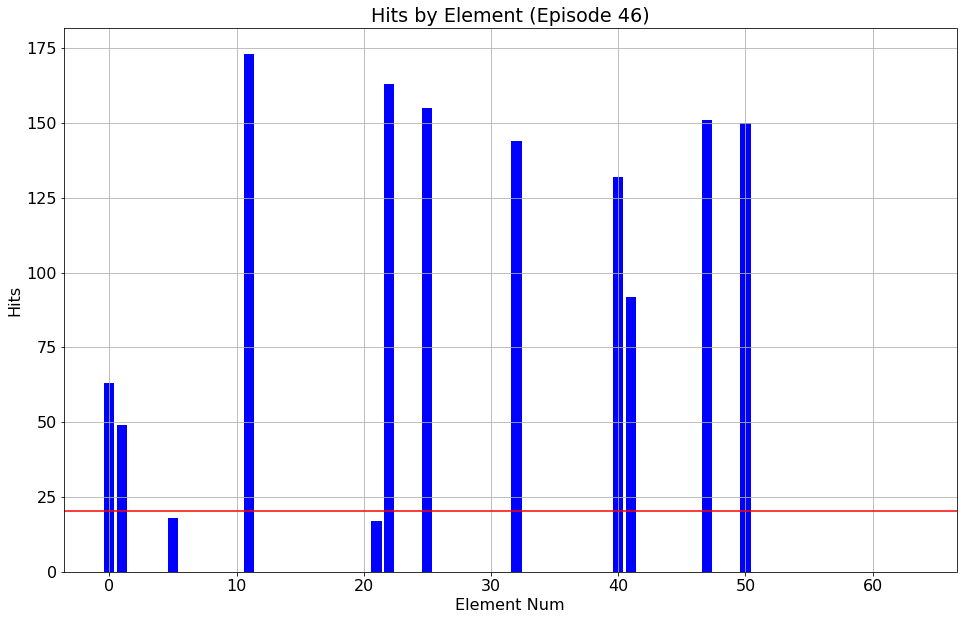


********************************************************************************
Round 6: 2048 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 46: Epoch  161, Batch  10304
effective_learning_rate=3.815e-06, training_time 452 sec.
Train on 4096 samples
Epoch 162/165
4096/4096 [==============================] - 6s 1ms/sample - loss: -249342754.8750
Epoch 163/165
4096/4096 [==============================] - 3s 664us/sample - loss: -259033113.5000
Epoch 164/165
4096/4096 [==============================] - 3s 671us/sample - loss: -259415387.0000
Epoch 165/165
4096/4096 [==============================] - 3s 673us/sample - loss: -259800896.0000
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (12)
Geom Mean Resolution:    134

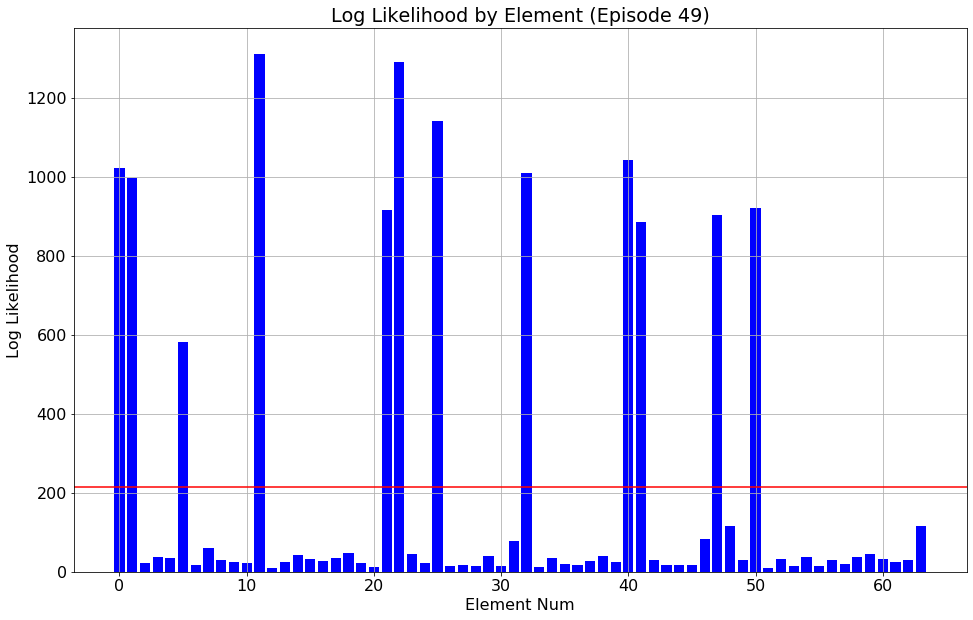

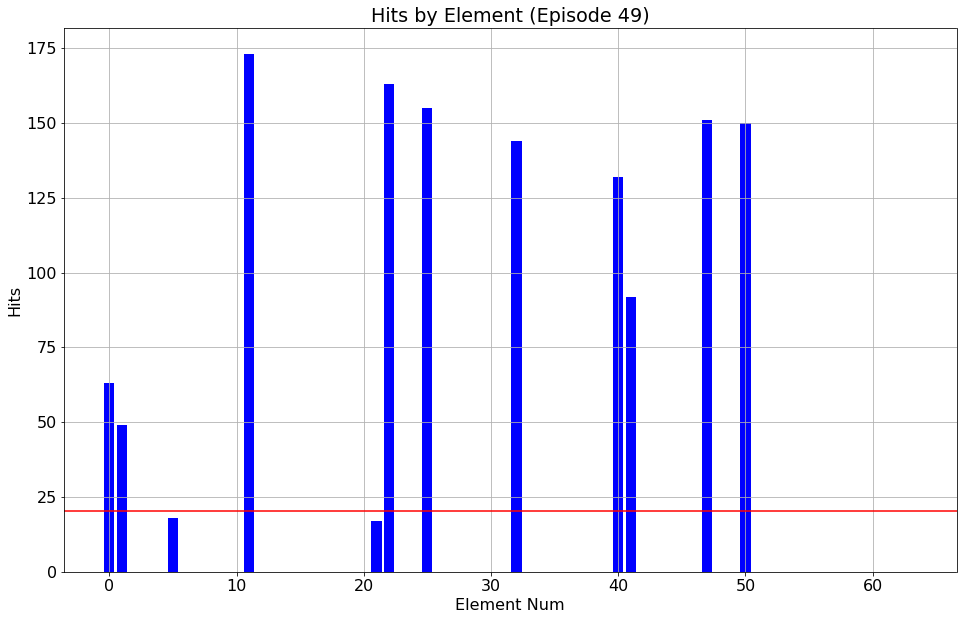


********************************************************************************
Round 7: 512 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 49: Epoch  173, Batch  11072
effective_learning_rate=3.815e-06, training_time 493 sec.
Train on 4096 samples
Epoch 174/177
4096/4096 [==============================] - 5s 1ms/sample - loss: -10153523789824.0000
Epoch 175/177
4096/4096 [==============================] - 3s 669us/sample - loss: -10583675568128.0000
Epoch 176/177
4096/4096 [==============================] - 3s 674us/sample - loss: -10604941606912.0000
Epoch 177/177
4096/4096 [==============================] - 3s 666us/sample - loss: -10621599203328.0000
Adjusted element weight down on 22 candidate elements. Mean weight = 8.28e-01
                    \  All Elts : Bad Elts : Good Elts (11)
Geom Mean Resolution:    134.29 :   227.86 :

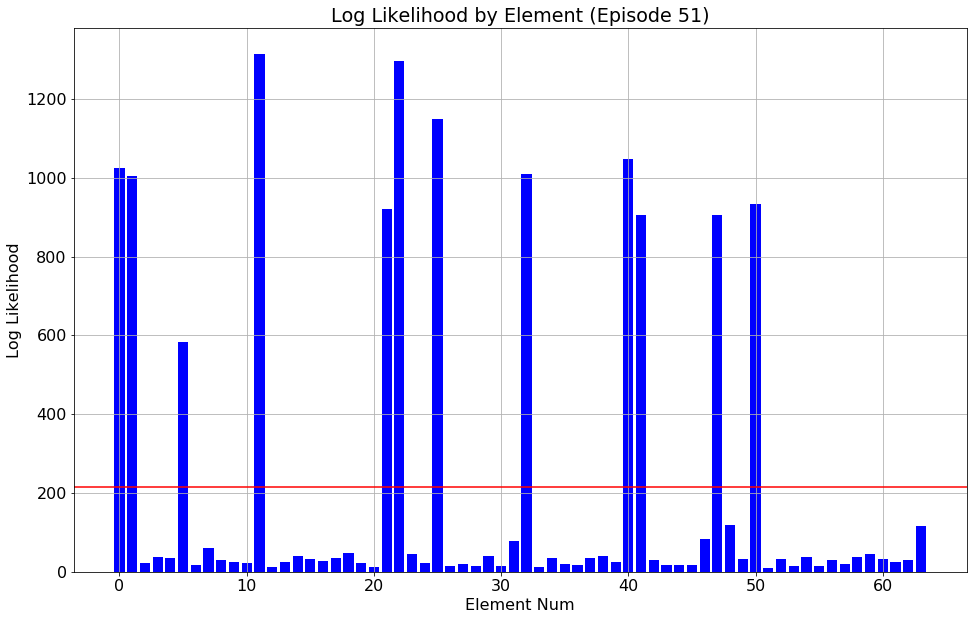

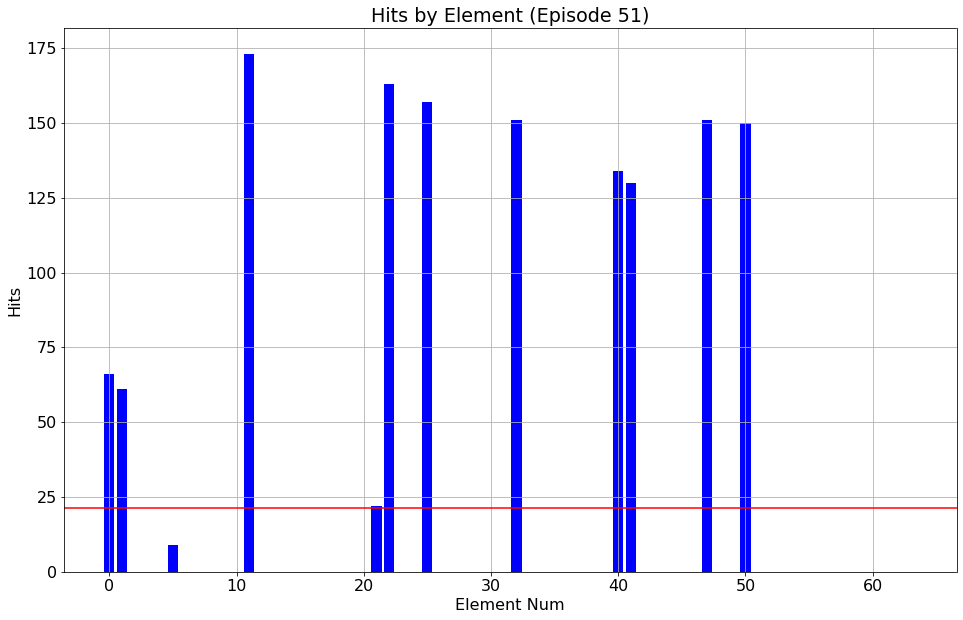

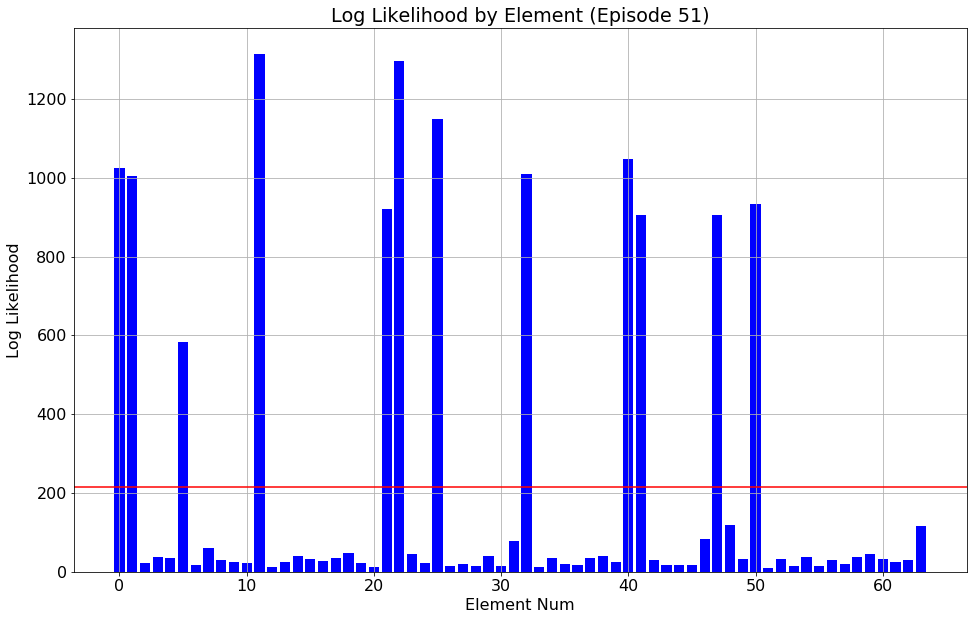

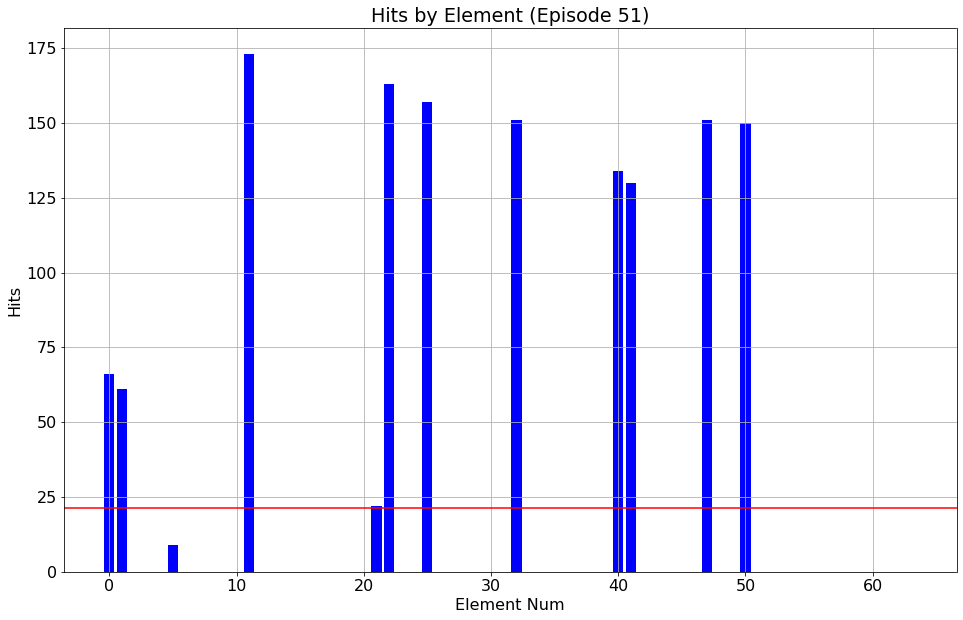

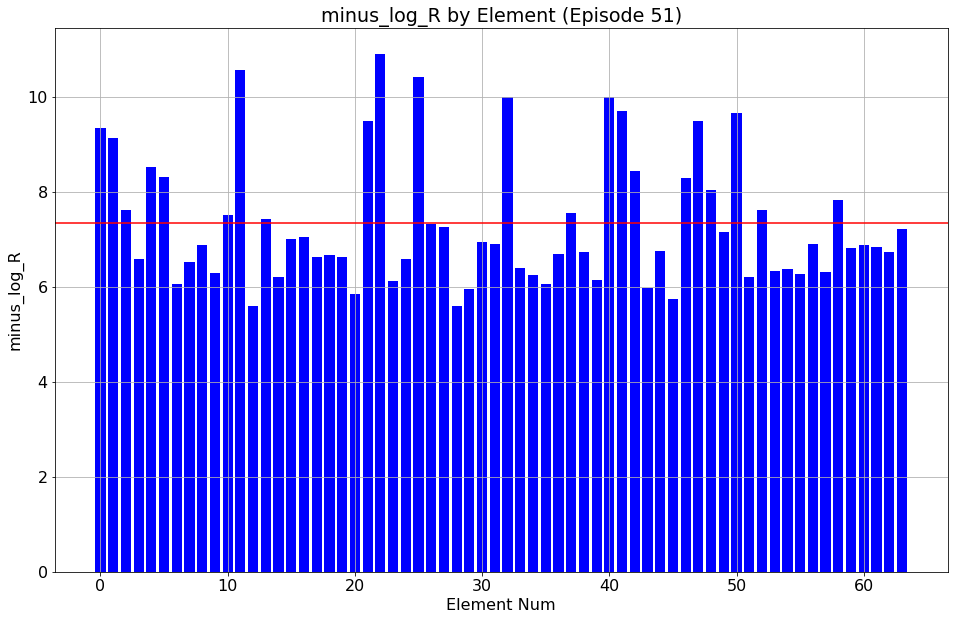

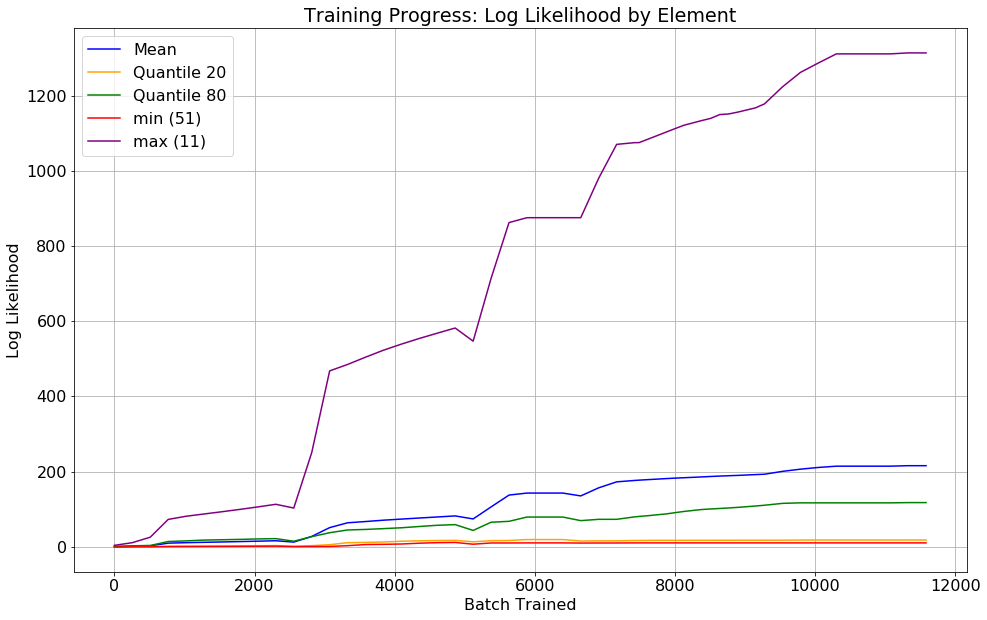

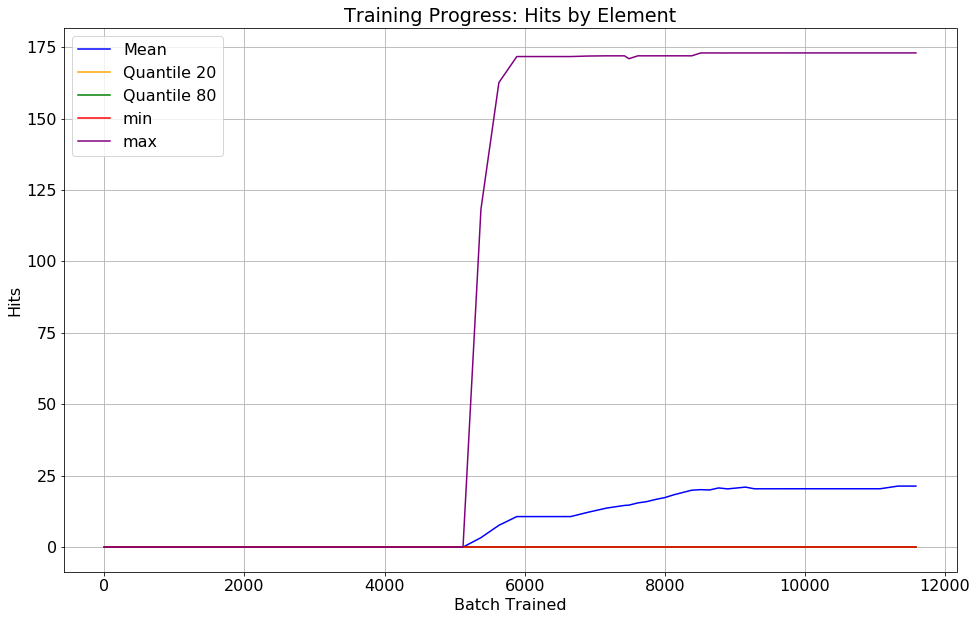

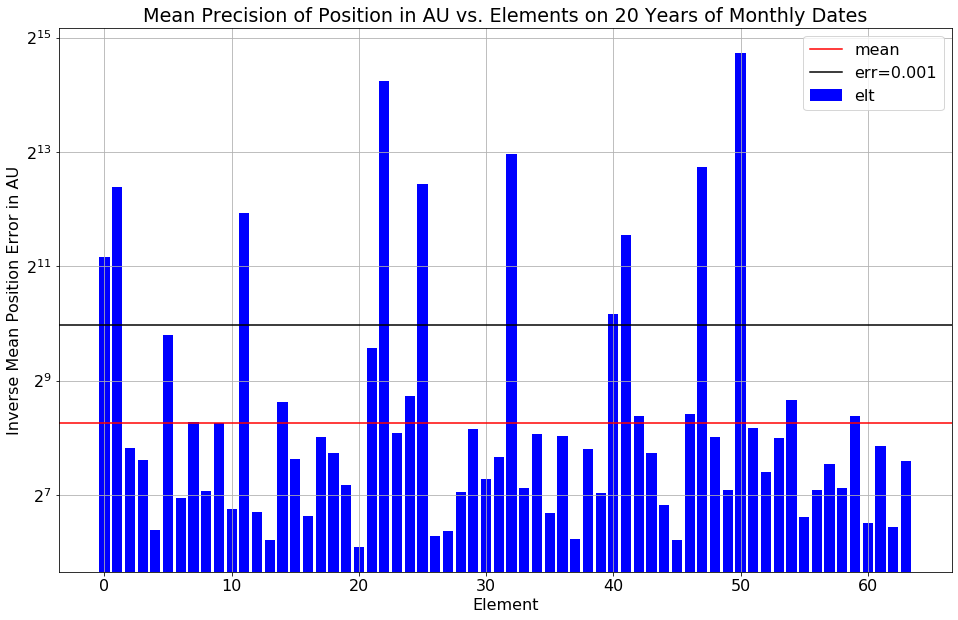

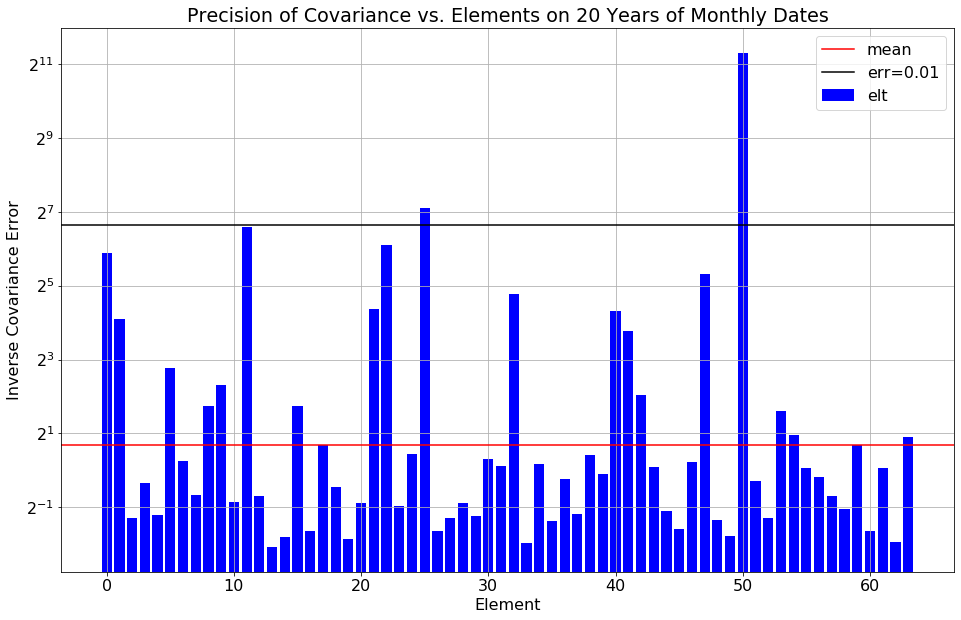

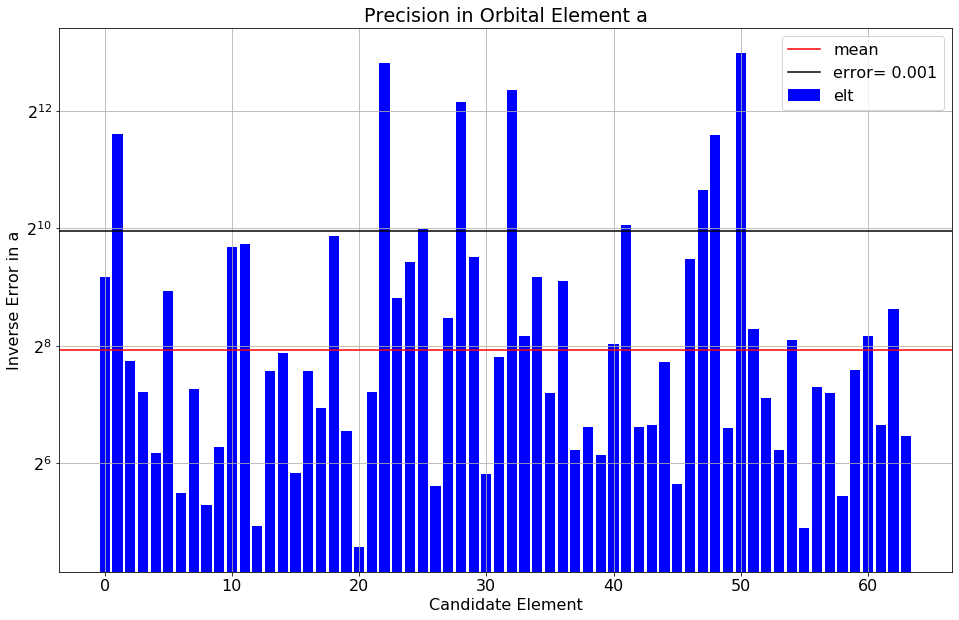

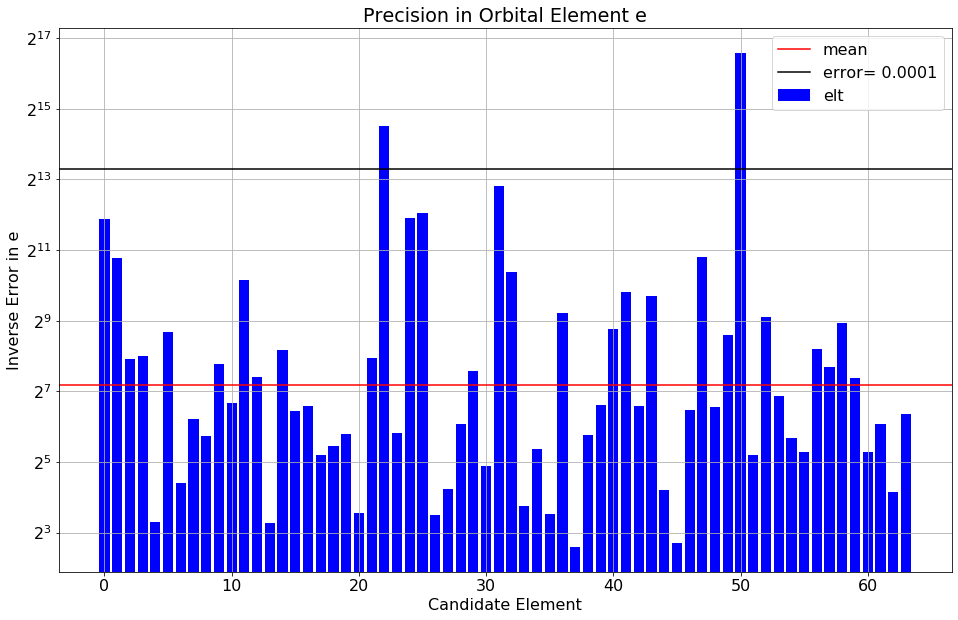

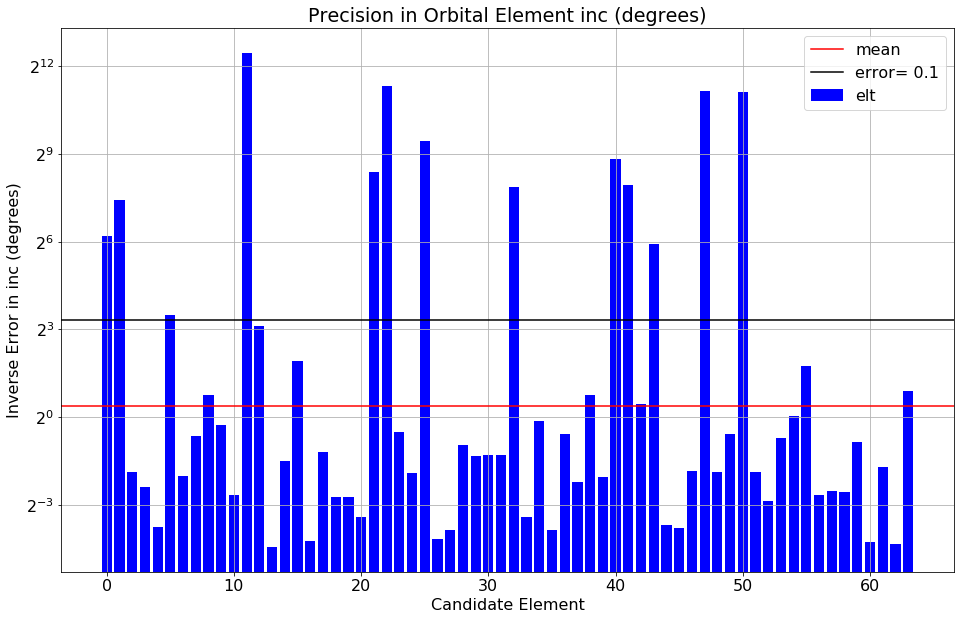

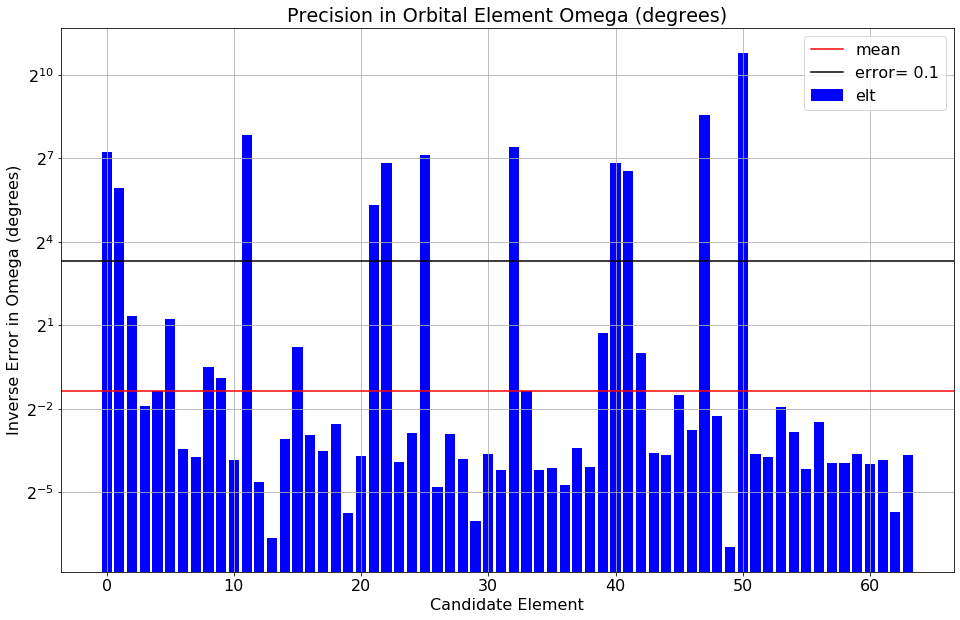

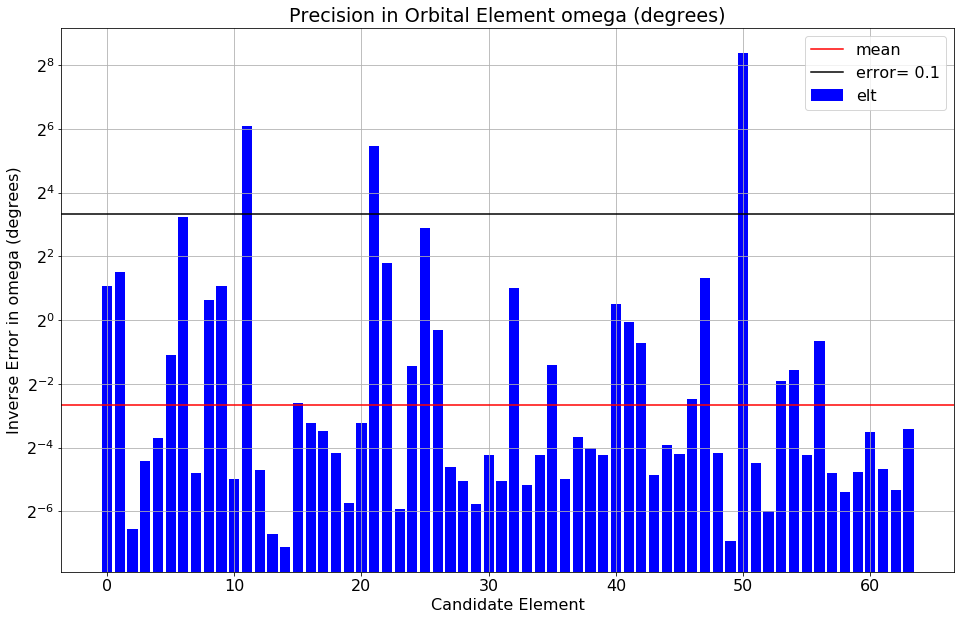

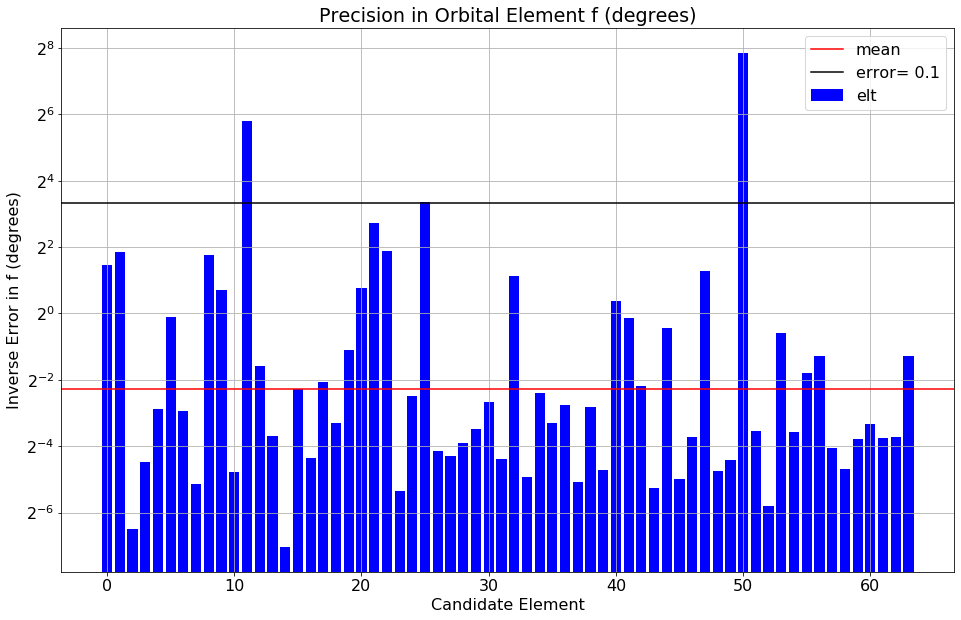

In [36]:
model.sieve()

In [37]:
model.report()


Good elements (hits >= 10):  11.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:  1046.97  : 123.45 :    11.92 :   510.63
Mean Bad :    42.98  :   0.17 :   284.46 :  2350.34
Mean     :   215.54  :  21.36 :   237.62 :  2034.14
Median   :    32.67  :   0.00 :   211.42 :  2400.00
GeoMean  :    53.59  :   1.32 :   136.36 :  1797.06
Min      :    10.03  :   0.00 :     3.79 :   316.04
Max      :  1314.28  : 173.00 :   763.11 :  2400.00
Trained for 11584 batches over 181 epochs and 51 episodes (elapsed time 522 seconds).


## Distance vs. Nearest Asteroid for Fitted Elements

In [38]:
_ = model.nearest_ast()

In [39]:
model.report()


Good elements (hits >= 10):  11.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:  1046.97  : 123.45 :    11.92 :   510.63
Mean Bad :    42.98  :   0.17 :   284.46 :  2350.34
Mean     :   215.54  :  21.36 :   237.62 :  2034.14
Median   :    32.67  :   0.00 :   211.42 :  2400.00
GeoMean  :    53.59  :   1.32 :   136.36 :  1797.06
Min      :    10.03  :   0.00 :     3.79 :   316.04
Max      :  1314.28  : 173.00 :   763.11 :  2400.00
Trained for 11584 batches over 181 epochs and 51 episodes (elapsed time 522 seconds).


In [40]:
# model.save_state()

In [41]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 11 asteroids.
Mean on converged asteroids:
Number of hits         : 123.43
Resolution in arc sec  : 11.92
GeoMean Distance in AU : 2.17e-04
Covariance norm        : 1.82e-02


In [42]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
11,9936,1314.278320,172.997208,5.338224,388.878723,9936,0.000255,0.010428
22,9229,1296.378906,162.998383,3.789439,316.036469,9229,0.000052,0.014728
25,203722,1148.584473,156.999176,6.103843,351.422852,203722,0.000180,0.007322
47,733,906.112549,150.973267,15.655526,528.989929,733,0.000146,0.025290
32,19794,1011.076172,150.952774,9.294221,538.611511,19794,0.000124,0.036628
50,6455,933.200684,149.969269,13.242359,535.431335,6455,0.000037,0.000398
40,31539,1048.273193,133.993164,9.336583,525.352112,31539,0.000870,0.050708
41,3426,906.144348,129.942490,12.484340,563.649597,3426,0.000335,0.072758
0,51921,1025.239624,65.980774,17.989109,607.918091,51921,0.000439,0.016801
1,59244,1005.729614,60.983906,22.376781,645.778381,59244,0.000187,0.058748


In [43]:
# # Review fitted elements including nearest asteroid
model.elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,51921,2.667584,0.217094,0.499315,4.699821,2.442383,-1.127215,58600.0,194.790466,0.000087,...,0.168866,607.918091,1025.239624,65.980774,225.0,15.172626,3.235940,51921,0.000439,0.016801
1,59244,2.634408,0.263069,0.464944,5.738015,1.773176,-1.606155,58600.0,189.895325,0.000108,...,0.179383,645.778381,1005.729614,60.983906,210.0,14.631936,2.943305,59244,0.000187,0.058748
2,15786,1.919150,0.045279,0.380010,6.132791,0.780181,-1.246853,58600.0,17.768497,0.000495,...,0.666667,2399.999756,21.771929,0.000000,378.0,15.045182,3.211812,425432,0.004423,2.438487
3,3904,2.991567,0.121658,0.254012,5.545333,2.211871,-1.321231,58600.0,61.200359,0.001377,...,0.666667,2399.999756,37.416889,0.000000,519.0,18.394489,3.062401,103630,0.005109,1.276871
4,142999,2.520716,0.183272,0.503950,0.210395,0.932469,-1.333871,58600.0,14.977539,0.000199,...,0.666667,2399.999756,35.657852,0.000000,420.0,18.501894,2.992854,451765,0.011895,2.323656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330739,0.107349,0.106177,0.109833,2.863452,-3.001412,58600.0,83.109070,0.001101,...,0.666667,2399.999756,45.881573,0.000000,1302.0,18.461105,2.991879,64103,0.003006,0.627123
60,134815,2.372121,0.104635,0.496005,0.227768,0.599330,-0.897907,58600.0,39.340637,0.001034,...,0.666667,2399.999756,33.148060,0.000000,365.0,17.094486,2.904491,202031,0.010918,3.135246
61,27860,2.598073,0.097974,0.194372,5.533032,3.258370,3.967845,58600.0,50.897964,0.001064,...,0.666667,2399.999756,24.978907,0.000000,988.0,18.037214,3.226311,1047580,0.004327,0.964321
62,85937,2.198824,0.194209,0.435657,5.234495,3.113885,3.989790,58600.0,41.308353,0.001176,...,0.666667,2399.999756,29.718346,0.000000,385.0,15.581556,3.199641,438415,0.011535,3.850016


In [44]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

,element_id,num_hits,R_sec,thresh_sec,log_like,hits,nearest_ast_dist,nearest_ast_q_norm
22,9229,162.977432,3.789439,316.036469,1296.378906,162.998383,0.000052,0.014728
11,9936,173.006699,5.338224,388.878723,1314.278320,172.997208,0.000255,0.010428
25,203722,161.977692,6.103843,351.422852,1148.584473,156.999176,0.000180,0.007322
32,19794,159.928711,9.294221,538.611511,1011.076172,150.952774,0.000124,0.036628
40,31539,153.990906,9.336583,525.352112,1048.273193,133.993164,0.000870,0.050708
41,3426,152.929794,12.484340,563.649597,906.144348,129.942490,0.000335,0.072758
50,6455,150.006195,13.242359,535.431335,933.200684,149.969269,0.000037,0.000398
21,77774,163.931061,15.532451,614.871460,921.647583,21.994614,0.001310,0.048849
47,733,150.973404,15.655526,528.989929,906.112549,150.973267,0.000146,0.025290
0,51921,194.790466,17.989109,607.918091,1025.239624,65.980774,0.000439,0.016801


In [45]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

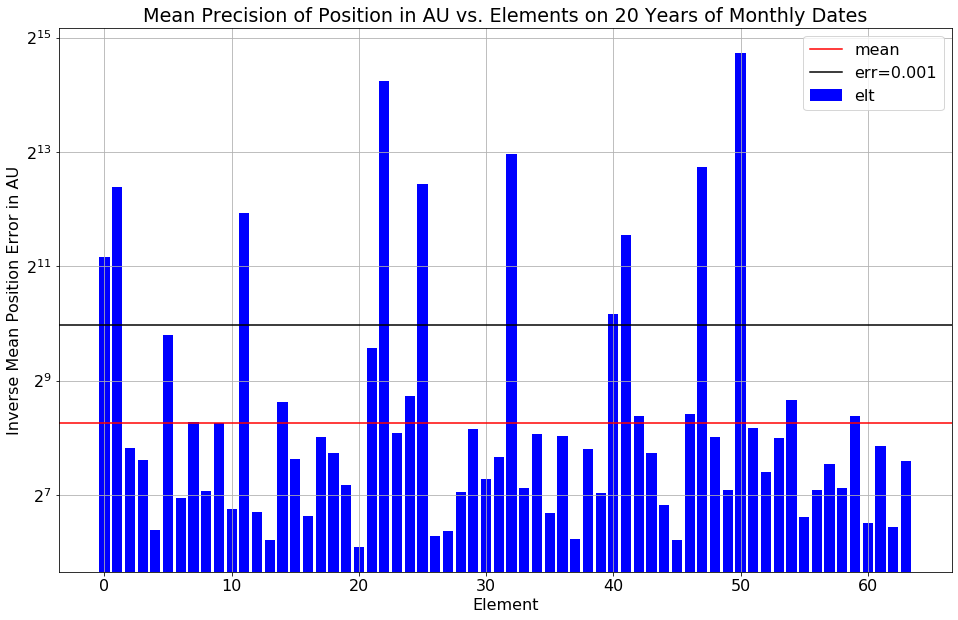

In [46]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

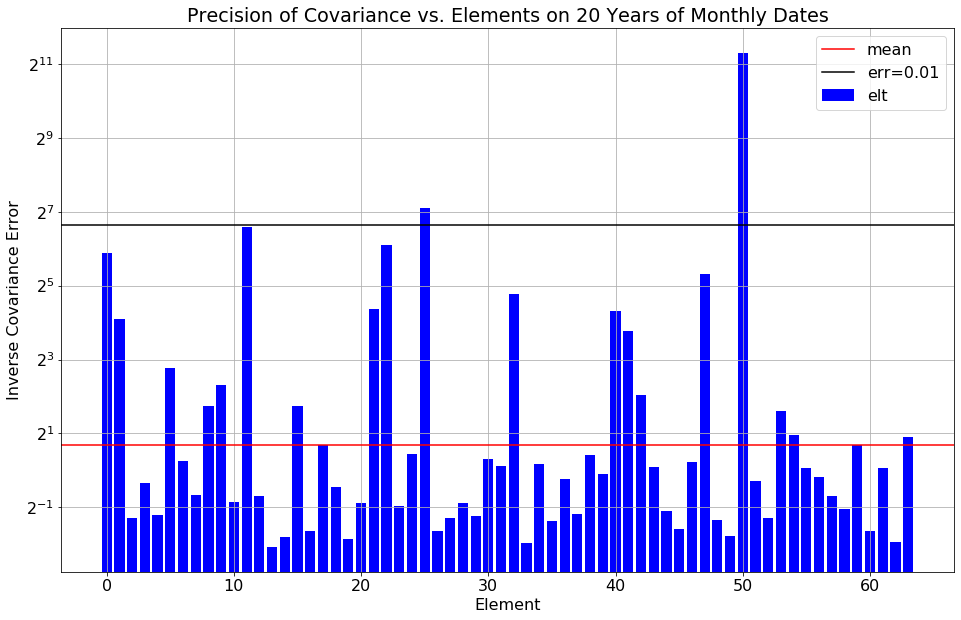

In [47]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

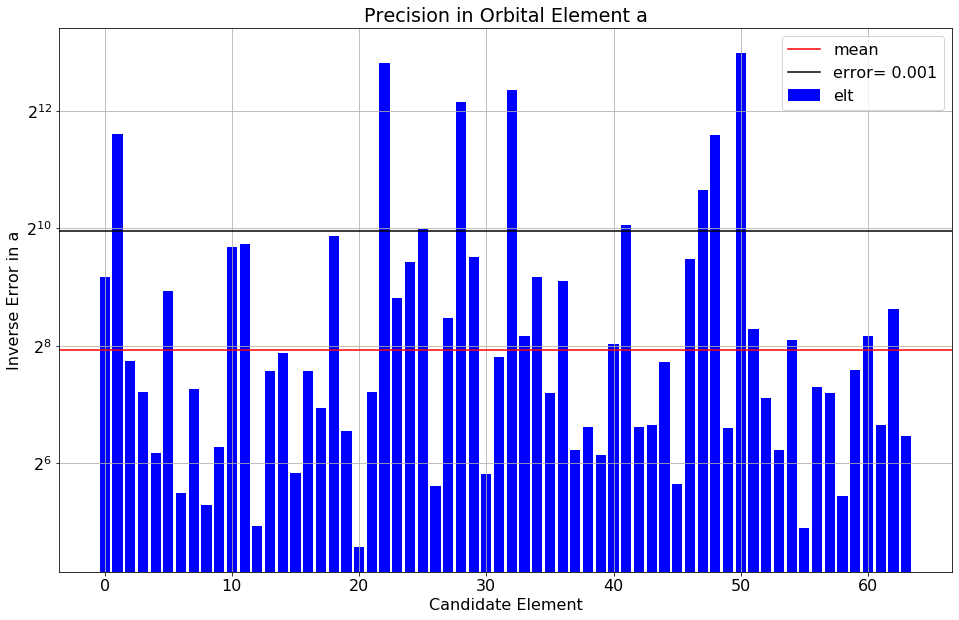

In [48]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

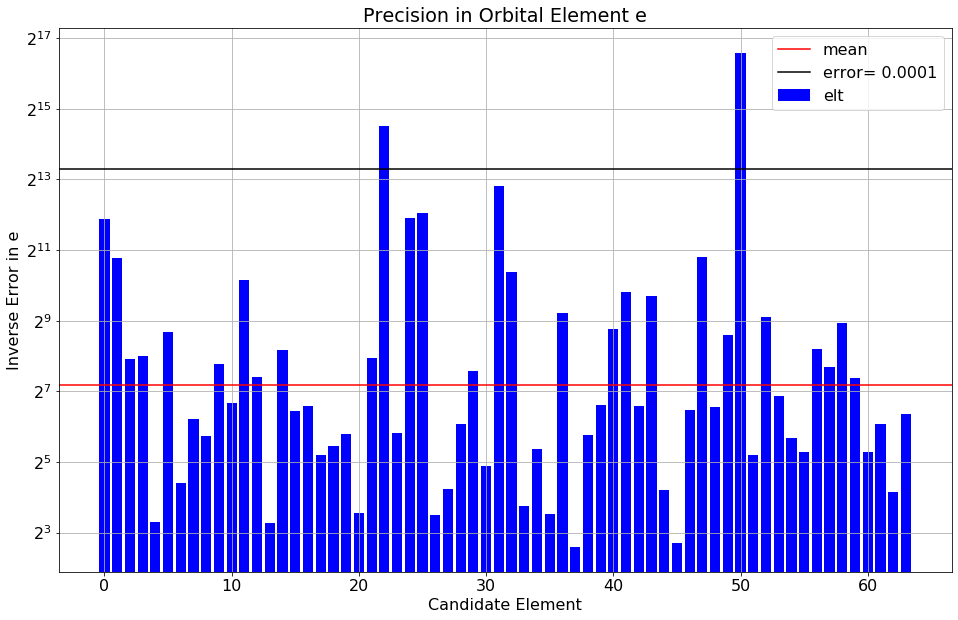

In [49]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

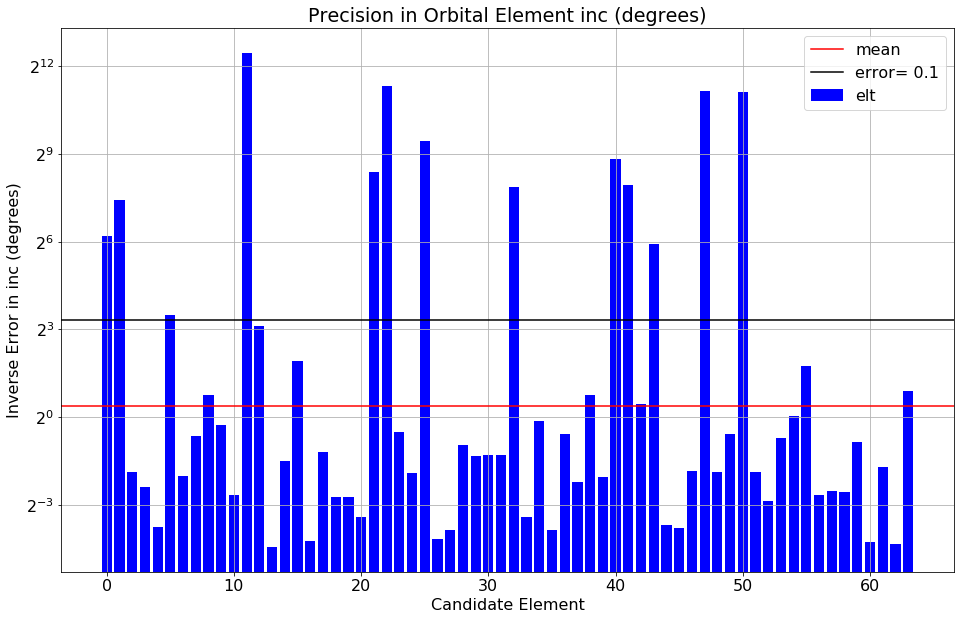

In [50]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

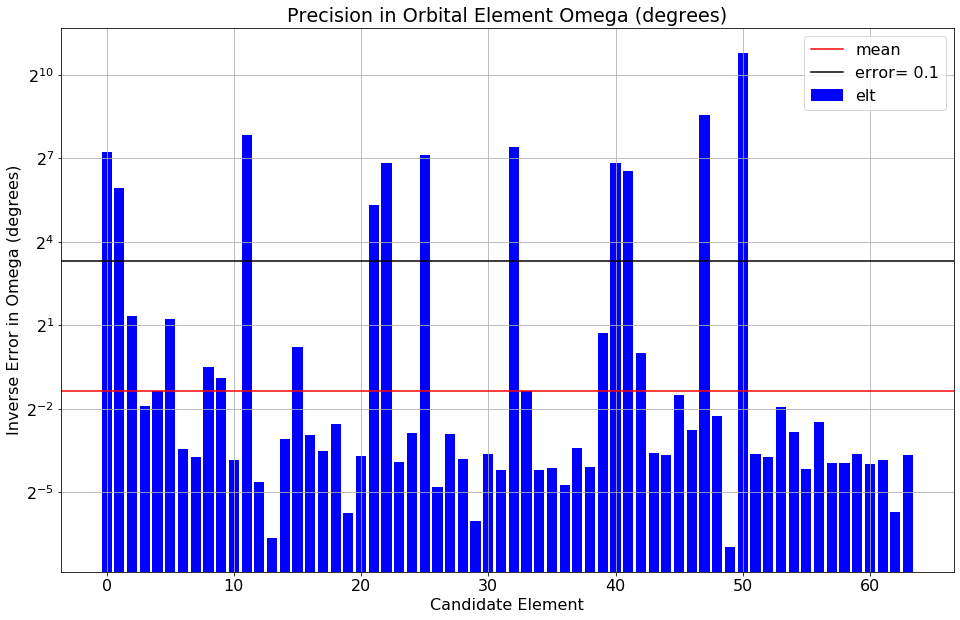

In [51]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

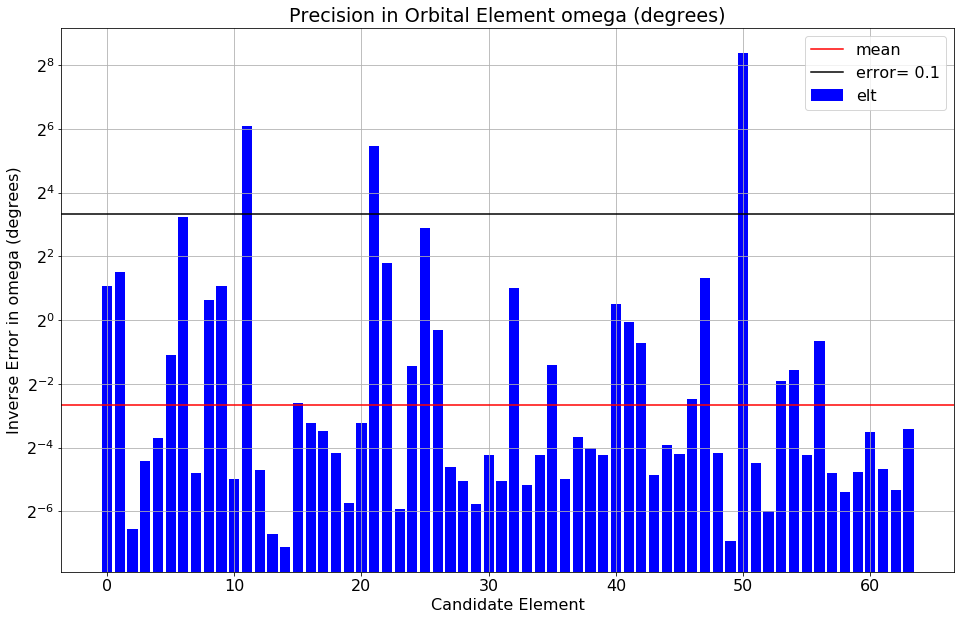

In [52]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

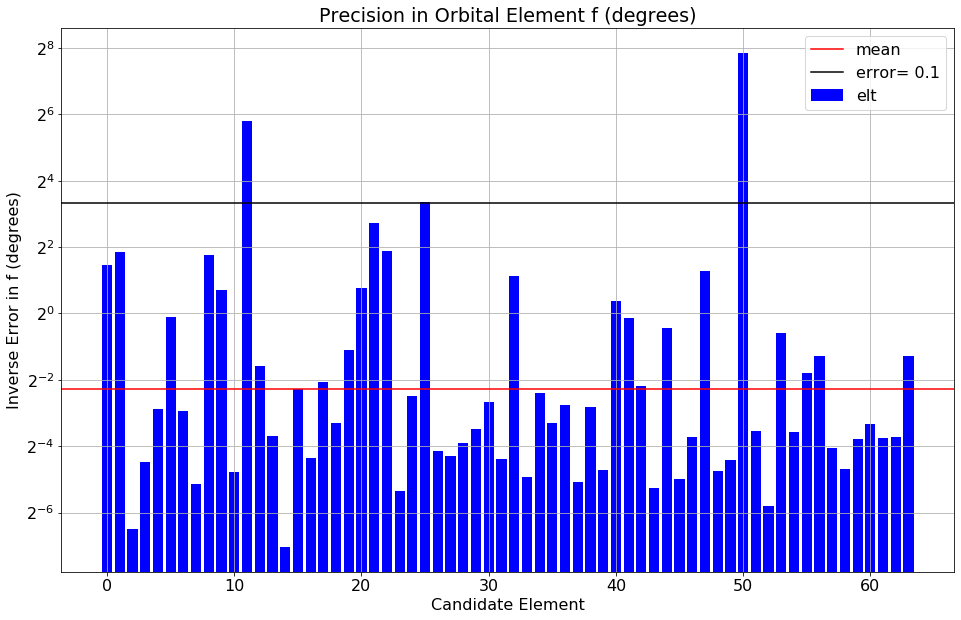

In [53]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)

In [54]:
model.candidates_df()

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,weight_joint,weight_element,weight_mixture
0,51921,2.667584,0.217094,0.499315,4.699821,2.442383,-1.127215,58600.0,194.790466,0.000087,...,0.168866,607.918091,1025.239746,65.980774,225.0,15.172626,3.235940,0.50,1.0,0.1250
1,59244,2.634408,0.263069,0.464944,5.738015,1.773176,-1.606155,58600.0,189.895325,0.000108,...,0.179383,645.778381,1005.729553,60.983898,210.0,14.631936,2.943305,0.50,1.0,0.5000
2,15786,1.919150,0.045279,0.380010,6.132791,0.780181,-1.246853,58600.0,17.768497,0.000495,...,0.666667,2399.999756,21.771929,0.000000,378.0,15.045182,3.211812,0.50,1.0,0.0625
3,3904,2.991567,0.121658,0.254012,5.545333,2.211871,-1.321231,58600.0,61.200359,0.001377,...,0.666667,2399.999756,37.416885,0.000000,519.0,18.394489,3.062401,0.50,1.0,0.0625
4,142999,2.520716,0.183272,0.503950,0.210395,0.932469,-1.333871,58600.0,14.977539,0.000199,...,0.666667,2399.999756,35.657852,0.000000,420.0,18.501894,2.992854,0.25,1.0,0.0625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330739,0.107349,0.106177,0.109833,2.863452,-3.001412,58600.0,83.109070,0.001101,...,0.666667,2399.999756,45.881557,0.000000,1302.0,18.461105,2.991879,0.25,1.0,0.0625
60,134815,2.372121,0.104635,0.496005,0.227768,0.599330,-0.897907,58600.0,39.340637,0.001034,...,0.666667,2399.999756,33.148102,0.000000,365.0,17.094486,2.904491,0.50,1.0,0.1250
61,27860,2.598073,0.097974,0.194372,5.533032,3.258370,3.967845,58600.0,50.897964,0.001064,...,0.666667,2399.999756,24.978907,0.000000,988.0,18.037214,3.226311,0.25,1.0,0.0625
62,85937,2.198824,0.194209,0.435657,5.234495,3.113885,3.989790,58600.0,41.308353,0.001176,...,0.666667,2399.999756,29.718348,0.000000,385.0,15.581556,3.199641,0.25,1.0,0.0625
